In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports and Project Path

In [2]:
# setting project path
import os, sys, warnings

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# importing packages
import os, sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from src import class_Database as d
from src import helper_functions as f
from src import visualizations as v
from src import class_Harness as h

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

time: 2.3 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.36 ms


**Run the cell below once to populate the database. After the database is populated, the cell can be commented out.**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 436 µs


## Modeling Harrnes Objects

In [5]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 2.72 ms


## EDA & Rocommendations Data Frames

In [6]:
# creating the student_info data frame
student_info = db.student_info_full()

# cleaning the data
student_info = db.cleaner_studentinfo(student_info,[])

# creating assessment_vle data frame
assessment_vle = db.data_prep_full()

# cleaning the data and engineering features
drops = ['row_id', 'studied_credits',
         'id_site', 'sum_click', 'date_sub', 'date',
         'course_length', 'max_date']
assessment_vle = db.pipe_cleaner_wa(assessment_vle, drops).reset_index(drop=True)

time: 15.5 s


## Modeling Data Frame

In [7]:
# creating the modeling data frame
df = db.data_prep_half(120)

# cleaning the data
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date', 'code_module',
         'code_presentation', 'id_student', 'activity_level']
df = db.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 10.2 s


## Creating Holdout Data

In [8]:
# splitting data & target
X, y = f.X_y(df)

time: 2.4 ms


In [9]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 9.36 ms


## Creating Testing Data

In [10]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.68 ms


# Online Outcomes: Predicting Success in Virtual Learning

**<font size="4">Author: Jeffrey Hanif Watson</font>**

## Overview

***
## Business Understanding
In the years before the pandemic, online learning had been enjoying reliable, if unspectacular, growth <sup>1</sup>, and was predicted to become a \$350 Billion global market by 2025.<sup>2</sup> Covid-19 has only accelerated this trend, with examples such as the online learning platform edX experiencing a 15-fold growth in registrations in April 2020<sup>3</sup>, and almost 93\% of school-age children engaged in online learning in 2020.<sup>4</sup> 

While the growth in online learning can provide opportunites, it  also raises concerns about student engagement, learning loss, and inequality. According to a recent survey , the main concern of over 70\% of college students is staying engaged with their course materials online<sup>5</sup>, while the World Bank also reports that school closures and online learning have led to widespread learning loss across Europe and Central Asia<sup>6</sup>, and Harvard Professor Todd Rose notes that "Poor students and first-generation students often don’t do as well online."<sup>7</sup>

This project aims to develop recommendations for strategies to avoid unstatisfactory outcomes in online learning environments and implement a model that can predict unfavorable outcomes in a timely manner so interventions can be applied to improve those outcomes.

***
## Data Understanding

The data set for the project is the Open University Learning Analytics dataset.

The dataset was obtained as a compressed zip file containing 7 csv files of tabular data. After cleaning and EDA, the data was ultimately reduced to a modeling dataset 19,458 rows and 13 columns (12 features plus the target).

Citation:
Kuzilek, J., Hlosta, M. & Zdrahal, Z. Open University Learning Analytics dataset. Sci Data 4, 170171 (2017). [Article](https://doi.org/10.1038/sdata.2017.171)

Download Page:
[Open University Learning Analytics dataset](https://analyse.kmi.open.ac.uk/open_dataset)

ERD & Data Details:
[Schema & Data Description](https://analyse.kmi.open.ac.uk/open_dataset#description)

***
## Data Preparation: SQL & Object Oriented Methods

The SQL, data preparation and EDA experiments in this notebook were ultimately collected into data frame creation, data cleaning, and feature engineering OOP methods for a Database class. This was done so the methods could be implemented on the fly to create various data configurations in the modeling, error analysis, and recommendations notebooks. This code located in the [class_Database.py](./src/class_Database.py) file. 

## Data Prepartion: Overview

The data was collected into an SQL database, and a data frame was constructed from the various database tables. During the creation process, the multiclass `final_result` feature was binarized into a `target` feature with classes Satisfactory (Pass, Distinction), and Unsatisfactory (Withdrawn, Fail). A `row_id` feature was constructed to identify unique student-course-month combinations, and a `sum_activity` feature was added to quantify the level of a student's interaction with the course material. Lastly, `weighted_ave`, `mean_score`, and `median_score` were derived from the each row's  assessment data.

After the data frame was created various cosmetic fixes were applied to the data, and outliers were dropped from the `studied_credits`, `weighted_ave`, and `sum_activity` features using IQR fences. A categorical `course_load` feature was derived by binning `studied_credits`, and a categorical `activity_level` feature was created by binning `sum_activity`. The `course_load` feature was used during the modeling process, and `activity_level` was used for statistical testing when while investigating business recommendations. Lastly, null values and extraneous columns were dropped in preparation of the modeling process.

In order to be able to predict unsatisfactory outcomes while there is still time to intervene, we limited the model to data logged upto the halfway of the courses. Since the median course length is 240 days, a cutoff point of 120 days was chosen. Further, students who withdrew before the 120th day were dropped from the data, since their outcome was fully determined within the 120 day window.

Data cleaning details for the project can be found here:
[Data Cleaning/EDA Notebook](./notebooks/exploratory/cleaning_eda.ipynb)
***

## Exploring the Data

## Demographic Data

## Distribution of Final Results
For data spanning the full term, Pass and Withdrawn are the largest groupings 38\% and 32\% respectively, followed by Fail at almost 22\%. Distinction brings up the rear at 9\%.

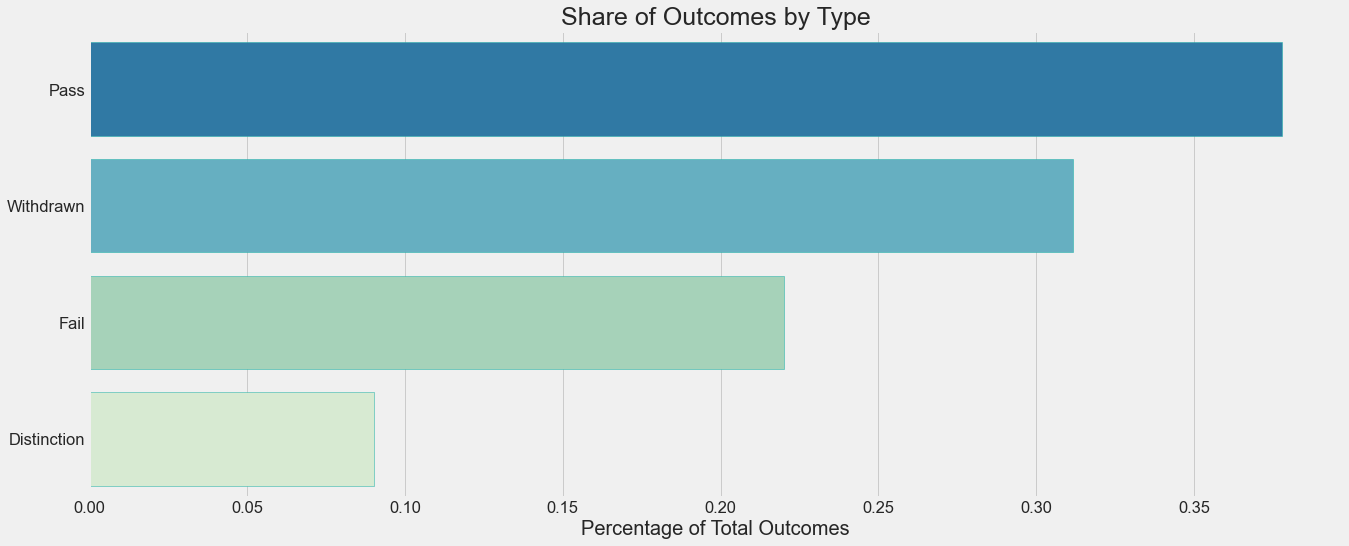

,Outcome,Percentage
0,Pass,0.377922
1,Withdrawn,0.311521
2,Fail,0.220203
3,Distinction,0.090354


time: 296 ms


In [11]:
v.outcomes_type(student_info,'outcomes_type')

## Distribution of Satisfactory and Unsatisfactory Outcomes
The final results were binarized into Satisfactory (Pass, Distinction) and Unsatisfactory (Withdrawn, Fail). About 46\% of outcomes were satisfactory, and 53\% were unsatisfactory. 

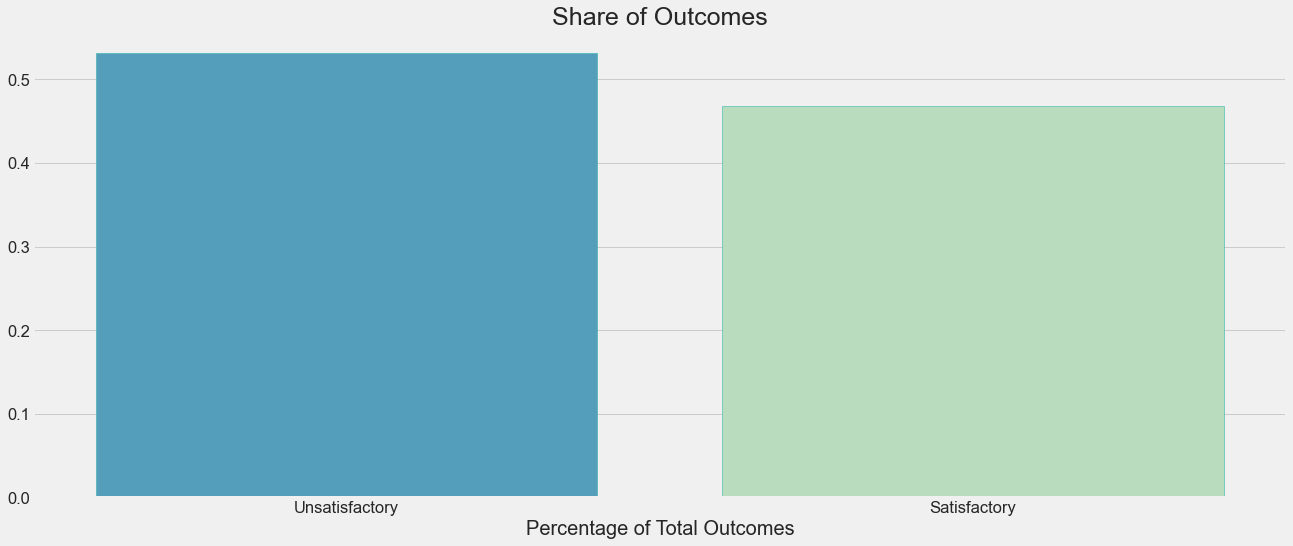

,Outcome,Percentage
0,Unsatisfactory,0.531724
1,Satisfactory,0.468276


time: 253 ms


In [12]:
v.outcomes_target(student_info, 'outcomes_bin')

## Outcome By IMD Band

IMD Band is a measure of socioeconomic status that is based on geographic location. The higher the band, the better off the student is.

Statistical testing was performed and it was found that IMD band and outcome are not independent. In general, Distinction and Pass vary directly with IMD band. The higher the student's IMD band, the more likely the student is to pass or pass with distinction. Conversely, Withdrawn and Fail vary inversely with IMD band. In general, the lower the student's IMD band the more likely the student is to fail or withdraw. 

IMD band has small, but statistically significant effect on the outcome Pass and Withdrawn, and a medium sized effect on Fail and Distinction.

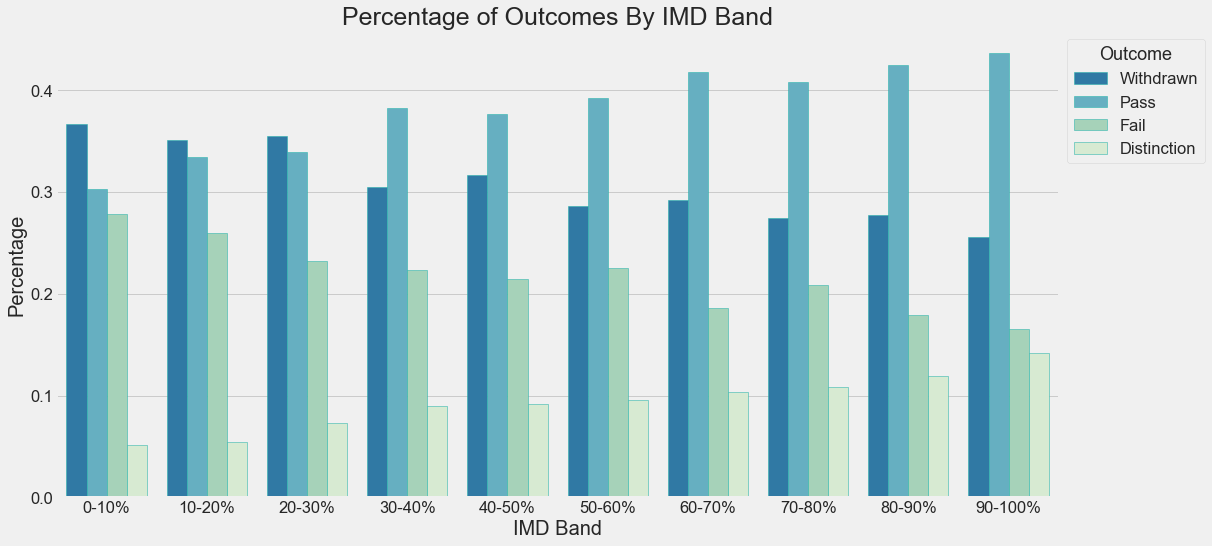

time: 518 ms


In [13]:
v.outcomes_imd(student_info, 'outcomes_imd')

### Investigating the IMD Band Contingency Table

In [14]:
# creating a contingency table
tabs = pd.crosstab(student_info.imd_band, student_info.final_result)

time: 25.7 ms


In [15]:
# creating a statsmodels table object
table = sm.stats.Table(tabs)

time: 767 µs


In [16]:
# pearsons residuals: negatives indicate fewer results than expected, positives indicate more.
table.resid_pearson

final_result,Distinction,Fail,Pass,Withdrawn
imd_band,,,,
0-10%,-7.402817,7.143362,-6.991624,5.681835
10-20%,-7.053337,5.017465,-4.146855,4.147654
20-30%,-3.462050,1.591755,-3.774848,4.683976
30-40%,-0.167062,0.358575,0.423810,-0.678298
40-50%,0.168598,-0.679618,-0.071974,0.559866
50-60%,0.955658,0.635117,1.338885,-2.523342
60-70%,2.403956,-3.938544,3.503514,-1.842207
70-80%,3.296277,-1.357454,2.609346,-3.507966
80-90%,5.004507,-4.631205,3.968319,-3.172347


time: 8.87 ms


From the contingency table it appears that, in general, Distinction and Pass vary directly with IMD band. The higher the student's IMD band, the more likely the student is to pass or pass with distinction. Conversely, Withdrawn and Fail vary inversely with IMD band. In general, the lower the student's IMD band the more likely the student is to fail or withdraw.

### Hypothesis Testing

#### Chi-Square Test for `imd_band`
Ho = `imd_band` and `final_result` are independent.

Ha = `imd_band` and `final_result` are not independent.

alpha = .05

In [17]:
# calculating chi-squared,p-value, degrees of freedom
f.chi_sq_test(tabs)

chi-squared = 653.0806826983792
p value= 2.473461324525511e-120
degrees of freedom = 27
time: 1.7 ms


Since the p value is less than our alpha, we reject the null hypothesis and conclude that `imd_band` and `final_result` are not independent.

#### Test Result: IMD Band and Outcomes Are Not Independent.

In [18]:
# calculating cramer's v to measure the effect sizes
f.cramers_v(tabs)

Cramer's V Degrees of Freedom = 3

Effect Size Thresholds
   Degrees of Freedom  Small Effect  Medium Effect  Large Effect
0                 1.0          0.10           0.30          0.50
1                 2.0          0.07           0.21          0.35
2                 3.0          0.06           0.17          0.29
3                 4.0          0.05           0.15          0.25
4                 5.0          0.04           0.13          0.22

final_result
Distinction    0.278138
Fail           0.178166
Pass           0.135999
Withdrawn      0.149793
dtype: float64
time: 7.33 ms


Adjusted for degrees of freedom, the Cramer's V results indicate that `imd_band` has a small, but statistically significant, effect on Pass and Withdrawn and a medium effect on Fail and Distinction.

#### Effect Sizes: Small for Pass and Withdrawn, Medium for Fail and Distinction.

## Outcome by Education Level
The rank of these UK education categories is as follows(from lowest to highest): No Formal Qualifications, Lower Than A Level, A Level, HE Qualification, Post Graduate Qualification.

Statistical testing was performed and it was found that education level and outcome are not independent. In general, Distinction and Pass vary directly with education level. The higher the student's education level, the more likely the student is to pass or pass with distinction. Conversely, Withdrawn and Fail vary inversely with education. In general, the lower the student's education level the more likely the student is to fail or withdraw. 

Education level has a medium effect on Pass, Fail, and Withdrawn, and a large effect on Distinction.

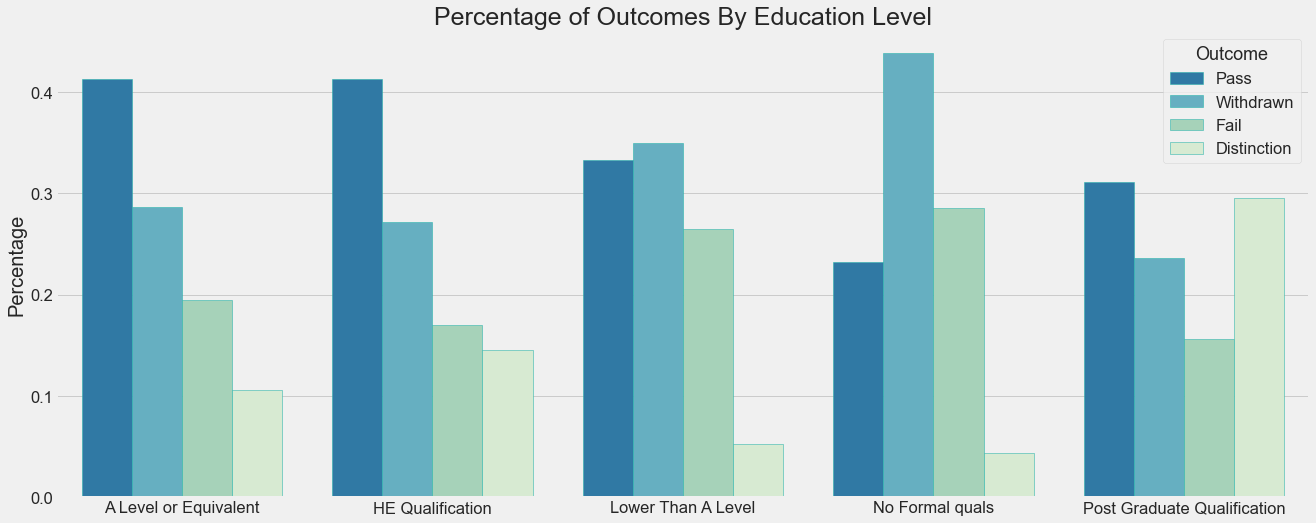

time: 431 ms


In [19]:
v.outcomes_edu(student_info, 'outcomes_edu')

### Investigating `highest_education` Contingency Tabels

In [20]:
# creating a contingency table
tabs = pd.crosstab(student_info.highest_education, student_info.final_result)

time: 22.9 ms


In [21]:
# creating a statsmodels table object
table = sm.stats.Table(tabs)

time: 825 µs


In [22]:
# pearsons residuals: negatives indicate fewer results than expected, positives indicate more.
table.resid_pearson

final_result,Distinction,Fail,Pass,Withdrawn
highest_education,,,,
A Level or Equivalent,5.891219,-6.327834,6.633103,-5.158524
HE Qualification,12.197479,-7.109027,3.760665,-4.734217
Lower Than A Level,-14.015472,10.604762,-8.259037,7.728913
No Formal quals,-2.761012,2.476404,-4.240230,4.075243
Post Graduate Qualification,9.316753,-1.868449,-1.466281,-1.831688


time: 6.36 ms


From the contingency tables it appears that, in general, Distinction and Pass vary directly with education level. The higher the student's education level, the more likely the student is to pass or pass with distinction. Conversely, Withdrawn and Fail vary inversely with education level. In general, the lower the student's education level the more likely the student is to fail or withdraw. 

### Chi-Square Test for `highest_education`
Ho = `highest_education` and `final_result` are independent.

Ha = `highest_education` and `final_result` are not independent.

alpha = .05

In [23]:
# calculating chi-squared,p-value, degrees of freedom
f.chi_sq_test(tabs)

chi-squared = 962.2117100356752
p value= 2.4827414817328365e-198
degrees of freedom = 12
time: 1.47 ms


Since the p value is less than our alpha, we reject the null hypothesis and conclude that `highest_education` and `final_result` are not independent.

#### Test Result: Education Level and Outcome Are Not Independent

In [24]:
# calculating cramer's v to measure the effect sizes
f.cramers_v(tabs)

Cramer's V Degrees of Freedom = 3

Effect Size Thresholds
   Degrees of Freedom  Small Effect  Medium Effect  Large Effect
0                 1.0          0.10           0.30          0.50
1                 2.0          0.07           0.21          0.35
2                 3.0          0.06           0.17          0.29
3                 4.0          0.05           0.15          0.25
4                 5.0          0.04           0.13          0.22

final_result
Distinction    0.337608
Fail           0.216260
Pass           0.165077
Withdrawn      0.181821
dtype: float64
time: 5.67 ms


Adjusted for degrees of freedom, the Cramer's V results indicate that `highest_education` has a medium effect on Pass, Fail, and Withdrawn, and a large effect on Distinction.

#### Effect Sizes: Medium on Pass, Fail and Withdrawn, Large on Distinction

## Recommendation

Preemptive outreach and support programs for non-traditional learners and lower income students, and inferential research into the advantages and disadvantages that socioeconomic status and education level confer in an academic setting to help refine those programs moving forward. 

## Outcome by Course Load
Course load is a feature that categorizes the amount of credits the student was studying at the time of the course. The categories are as follows: 

- 30-60 Credits: Light 
- 61 to 120 Credits: Medium
- 121 to 210 Credits: Heavy

Statistical testing was performed and it was found that course load and outcome are not independent. A light course load contributes positively to Distinction, Pass, and (counterintuitively) Fail, while it contributes negatively to Withdrawn. Conversely,  Medium and Heavy course loads contribute negatively to Distinction, Pass and (again, counterintuitively) Fail,  while they contribute positively to Withdrawn.

Course load has a small effect on Pass, a medium sized effect on Withdraw and Fail, and a large effect on Distinction.

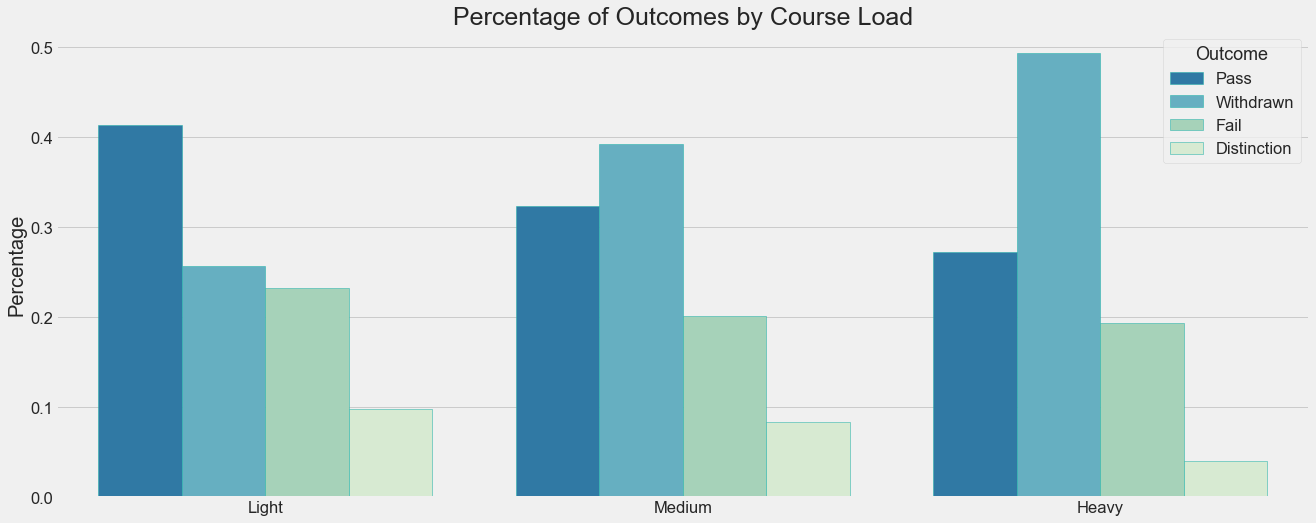

time: 360 ms


In [25]:
v.outcome_cl(student_info, 'outcomes_cl')

In [26]:
# creating a contingency table
tabs = pd.crosstab(student_info.course_load, student_info.final_result)

time: 15.8 ms


In [27]:
# creating a statsmodels table object
table = sm.stats.Table(tabs)

time: 654 µs


In [28]:
# pearsons residuals: negatives indicate fewer results than expected, positives indicate more.
table.resid_pearson

final_result,Distinction,Fail,Pass,Withdrawn
course_load,,,,
Light,3.796072,3.492519,8.141165,-13.947682
Medium,-2.331048,-4.005234,-8.556518,14.047233
Heavy,-7.185069,-2.405282,-7.369259,14.008549


time: 6.6 ms


From the contingency tables it appears that a light course load contributes positively to Distinction, Pass, and (counterintuitively) Fail, while it contributes negatively to Withdrawn. Conversely,  Medium and Heavy course loads contribute negatively to Distinction, Pass and (again, counterintuitively) Fail,  while they contribute positively to Withdrawn.

### Chi-Square Test for `course_load`
Ho = `course_load` and `final_result` are independent.

Ha = `course_load` and `final_result` are not independent.

alpha = .05

In [29]:
# calculating chi-squared,p-value, degrees of freedom
f.chi_sq_test(tabs)

chi-squared = 887.3947035023172
p value= 1.9942967713148247e-188
degrees of freedom = 6
time: 1.61 ms


Since the p value is less than our alpha, we reject the null hypothesis and conclude that `course_load` and `final_result` are not independent.

#### Result: Course Load and Outcome Are Not Independent

In [30]:
# calculating cramer's v to measure the effect sizes
f.cramers_v(tabs)

Cramer's V Degrees of Freedom = 2

Effect Size Thresholds
   Degrees of Freedom  Small Effect  Medium Effect  Large Effect
0                 1.0          0.10           0.30          0.50
1                 2.0          0.07           0.21          0.35
2                 3.0          0.06           0.17          0.29
3                 4.0          0.05           0.15          0.25
4                 5.0          0.04           0.13          0.22

final_result
Distinction    0.397083
Fail           0.254358
Pass           0.194158
Withdrawn      0.213852
dtype: float64
time: 4.51 ms


Adjusted for degrees of freedom, the Cramer's V results indicate that `course_load` has a small effect on Pass, a medium effect on Withdraw and Fail, and a large effect on Distinction.

#### Effect Sizes: Small on Pass, Medium on Withdrawn and Fail, Large on Distinction

## Recommendation
Encourage students to maintain a modest course load. We can see from the graph above that nearly half of the students will a heavy course load withdraw before the end of the course, and even at a medium load there are more withdraws than passes. Hopefully this data can be used to help set realistic expectations with students during matriculation.

## VLE & Assessment Data

## Activity Level
The `activity_level` feature is a measure of the student's engagment with a course's online materials, and is  calculated by adding the total number of online activities undertaken by the student with the total number of clicks for those activities. The categories are as follows:

- 2-456 Total: Very Light 
- 457-1013 Total: Light
- 1014-2029 Total: Medium 
- 2030-5402 Total: Heavy

Light activity levels contribute negatively to Distinction and  Pass, while they contributes positively to Withdrawn and Fail. Conversely,  Medium and Heavy activity levels contribute positively to Distinction and Pass, while they contribute negatively to Withdrawn and Fail.

`activity_level` has a large effect size on all of the outcomes, and the largest effect sizes of all the features tested.

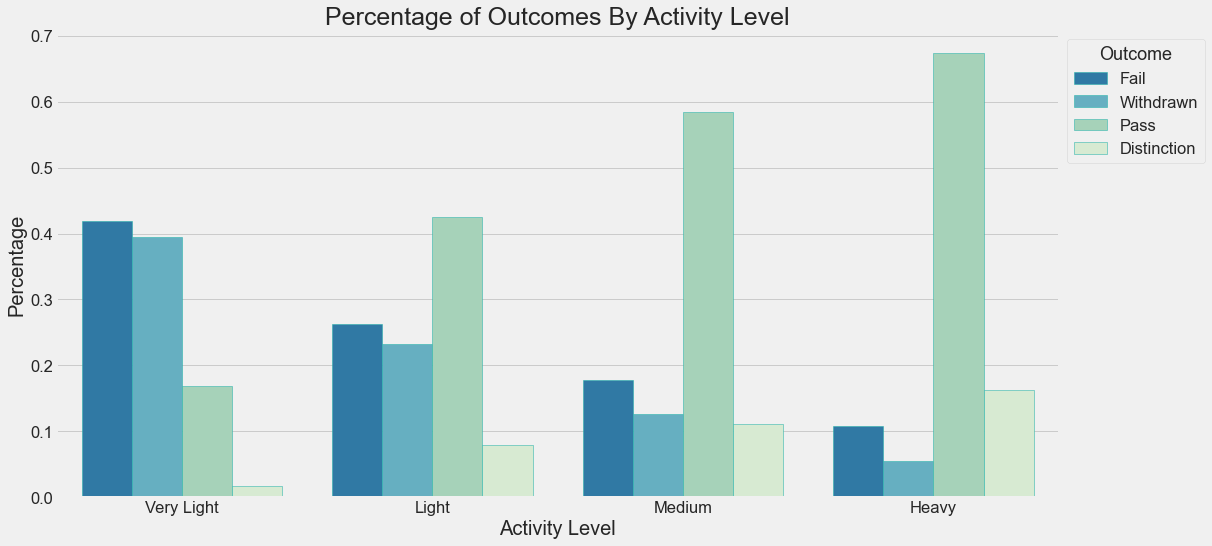

time: 347 ms


In [31]:
v.outcomes_sumact(assessment_vle, 'outcomes_sumact')

### Activity Level Contingency Table

In [32]:
# creating a contingency table
tabs = pd.crosstab(assessment_vle.activity_level, assessment_vle.final_result)

time: 17.2 ms


In [33]:
# creating a statsmodels table object
table = sm.stats.Table(tabs)

time: 842 µs


In [34]:
# pearsons residuals: negatives indicate fewer results than expected, positives indicate more.
table.resid_pearson

final_result,Distinction,Fail,Pass,Withdrawn
activity_level,,,,
Very Light,-18.228301,26.359702,-31.864838,31.241886
Light,-3.011017,2.820875,-3.809891,4.653149
Medium,4.649944,-9.770196,13.505704,-12.714837
Heavy,17.027465,-19.969095,22.828180,-23.852623


time: 7.12 ms


From the contingency tables it appears that light activity levels contribute negatively to Distinction and  Pass, while it contributes positively to Withdrawn and Fail. Conversely,  Medium and Heavy activity levels contribute positively to Distinction and Pass, while they contribute negatively to Withdrawn and Fail.

### Chi-Square Test for `activity_level`
Ho = `activity_level` and `final_result` are independent.

Ha = `activity_level` and `final_result` are not independent.

alpha = .05

In [35]:
# calculating chi-squared,p-value, degrees of freedom
f.chi_sq_test(tabs)

chi-squared = 5311.641369904437
p value= 0.0
degrees of freedom = 9
time: 1.2 ms


Since the p value is less than our alpha, we reject the null hypothesis and conclude that `activity_level` and `final_result` are not independent.

#### Test Result: Activity Level and Outcome Are Not Independent

In [36]:
# calculating cramer's v to measure the effect sizes
f.cramers_v(tabs)

Cramer's V Degrees of Freedom = 3

Effect Size Thresholds
   Degrees of Freedom  Small Effect  Medium Effect  Large Effect
0                 1.0          0.10           0.30          0.50
1                 2.0          0.07           0.21          0.35
2                 3.0          0.06           0.17          0.29
3                 4.0          0.05           0.15          0.25
4                 5.0          0.04           0.13          0.22

final_result
Distinction    0.945630
Fail           0.579352
Pass           0.421517
Withdrawn      0.632768
dtype: float64
time: 5.34 ms


Adjusted for degrees of freedom, the Cramer's V results indicate that `activity_level` has a large effect on all of the outcomes.

## Recommendation
Encourage students to maintain a medium or higher activity and initiate an automated reminder system that triggers when a student fall below a predetermined level. Also, initiate an web design assessment and A/B testing program with the goal of identifying ways of driving up student engagement.

# Modeling

Since we wanted to indentify as many unsatisfactory outcomes possible while still minimizing false positives,  F1 was used as the project as the metric. 

## Class Balance for the Modeling Data

In [37]:
df.target.value_counts(normalize=True)

0.0    0.640405
1.0    0.359595
Name: target, dtype: float64

time: 3.38 ms


## Features Used

The following features will be used in the modeling process:
    
-  gender: The gender of the student.
    
-  region: The geographic region of the student.
    
- highest_education: The education level of the student.
    
- imd_band: A measure of economic status based on geographic location.
    
- age_band: The age cohort of the student.
    
- num_of_prev_attempts: The number of times the student has attempted the class.
    
- disability: The disability status of the student.

- weighted_ave: The weighted average of the student's assessment scores.

- mean_score: The student's mean assessment score.

- median_score: The student's median assessment score.

- sum_activity: The sum of the activities, and the number of clicks for each activity, that the student logged.

- course_load: A three level categorization of the total credits the student was enrolled at the time of the  course.
    

## Summary Statistics for the Numerical Features

In [38]:
df.describe()

,target,num_of_prev_attempts,weighted_ave,mean_score,median_score,sum_activity
count,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000
mean,0.359595,0.140713,106.436972,74.288758,74.583256,901.266780
std,0.479894,0.449925,65.628103,15.207932,15.078946,724.074213
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,60.800000,66.400000,66.500000,345.000000
50%,0.000000,0.000000,113.020000,77.400000,77.500000,694.000000
75%,1.000000,0.000000,152.000000,85.000000,85.000000,1268.750000
max,1.000000,6.000000,299.920000,100.000000,100.000000,3179.000000


time: 24.9 ms


## Baseline Model: Dummy Classifier
The classifier will predict the majority class for each observation.

In [39]:
baseline = f.load_model('baseline')

time: 24.5 ms


### Average Training Metrics

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6403508735300234
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 198 ms


### Test Data Confusion Matrix

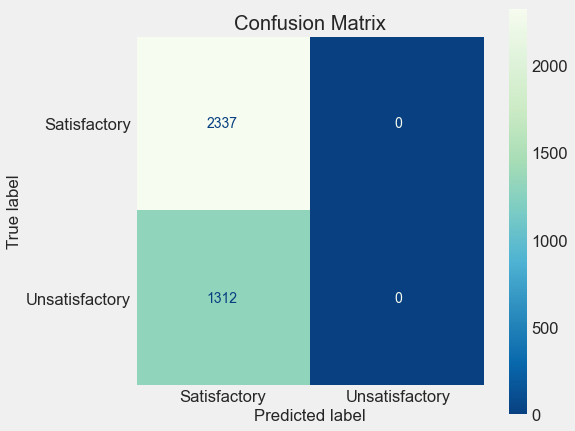

,Accuracy,F1,Recall,Precision
0,0.640449,0.0,0.0,0.0


time: 328 ms


In [41]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## Score Interpretation:

F1 is a mix of both precision and recall, so the interpretation of the results is more easily given in terms of recall and precision.

- From the confusion matrix we see that the baseline model is classifying everything as the majority class, which was expected.
- No outcomes were correctly classified as Unsatisfactory, so the recall score for this model is 0. 
- No outcomes were classified as Unsatisfactory, so the precision score (the proportion of outcomes classified as Unsatisfactory that were truly Unsatisfactory) is 0 as well.

## First Simple Model: Naive Bayes Classifier

In [42]:
fsm = f.load_model('fsm')

time: 2.95 ms


### Average Training Metrics

In [43]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6447369805651159
 fsm has an average F1 of 0.27759213371791497
 fsm has an average Recall of 0.18978579583201646
 fsm has an average Precision of 0.5175573546203541
time: 198 ms


### Test Data Confusion Matrix

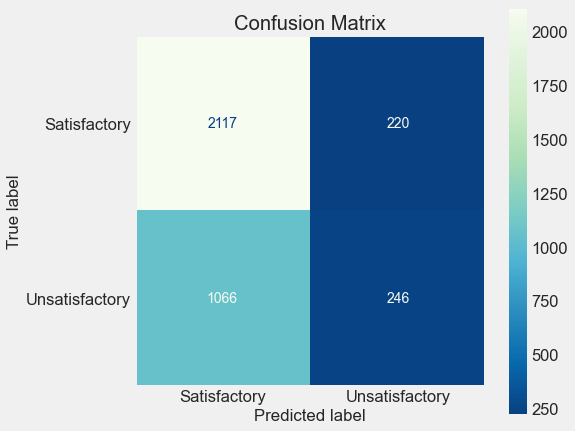

,Accuracy,F1,Recall,Precision
0,0.647575,0.276715,0.1875,0.527897


time: 287 ms


In [44]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

## Score Interpretation:

- From the confusion matrix we see that the fsm model is classifying outcomes slightly better than baseline.
- The recall score of .19 indicates that about 19% outcomes were correctly classified as Unsatisfactory. 
- The precision score .53 indicates that about 53% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# Intermediate Modeling and Adjustments

**Algorithms Tested**

KNN, Linear SVC , Decision Tree, Logistic Regression, AdaBoost, Support Vector CLF, Bagging CLF, Random Forest, XGBoost CLF

**Standard Scaling**

Since a few of the numerical features differ by orders of magnitude, standard scaling was implemented to aid in model convergence and performance.

**SMOTE**

Since the classes have an imbalance of around 2 to 1, SMOTE was added to the pipeline in an attempt to aid model performance.

**Hyper Parameter Tuning**

After the final model was chosen, hyperparameter tuning was performed using Random Search Cross validation.

# Final Model: Voting Classifier 
## (Bagging CLF, Random Forest CLF, XGBoost CLF)

In [45]:
best_model = f.load_model('final')

time: 445 ms


## Average Training Metrics

In [46]:
modeling.report(best_model, X_train, y_train, 'best_model',\
                'Tuned Voting CLF SS()/SMOTE SOFT')

best_model has an average Accuracy of 0.7593199920159213
best_model has an average F1 of 0.6613449865812424
best_model has an average Recall of 0.653456227142848
best_model has an average Precision of 0.6696263324427678
time: 14 s


### Test Data Confusion Matrix

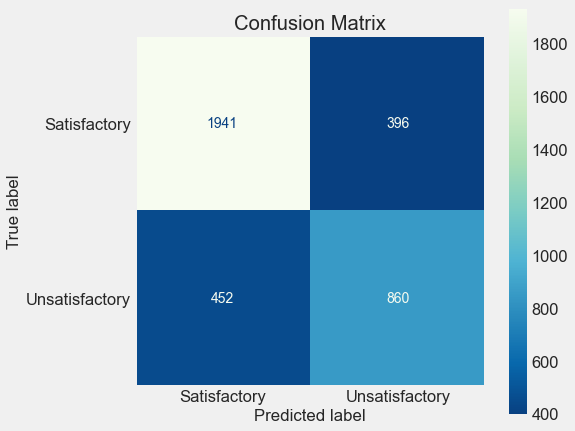

,Accuracy,F1,Recall,Precision
0,0.767608,0.669782,0.655488,0.684713


time: 813 ms


In [47]:
f.confusion_report(best_model, X_test, y_test, 'final_model')

## Score Interpretation:

Upon validation with the test data we see that the model is still having some trouble the minority class, but performance has been improved to a level that is acceptable for our purposes.

- The recall score of .66 indicates that about 66% outcomes were correctly classified as Unsatisfactory.
- The precision score .68 indicates that about 68% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

## Modeling Summary Average Training Scores

In [48]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.640351,0.000000,0.000000,0.000000,0.194712,Baseline DummyCFL
1,fsm,0.644737,0.277592,0.189786,0.517557,0.194607,FSM Naive Bayes
2,best_model,0.759320,0.661345,0.653456,0.669626,14.025514,Tuned Voting CLF SS()/SMOTE SOFT


time: 11 ms


# F1 Permutation Importances

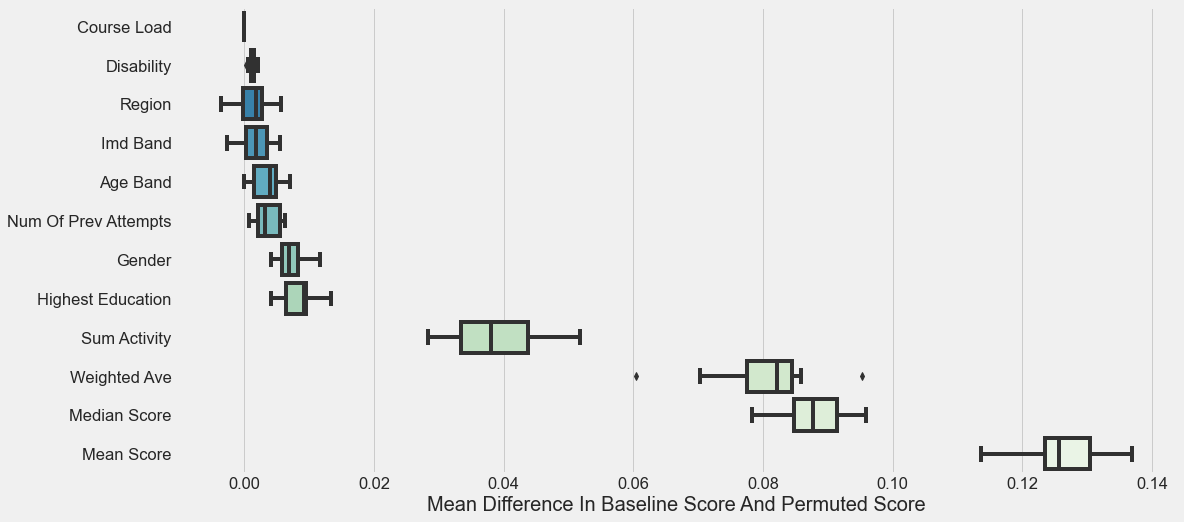

time: 7.1 s


In [49]:
f.perm_importances(best_model, X_test, y_test, 'f1', 'perm_importances')

The assessment score features (median_score, mean_score & weighted_ave) are the main drivers of the model, with mean_score being the greatest. Interestingly, some of the most statistically significant features (imd_band, highest_education, and course_load) have little to no effect on the model.

# Validating the Model on Holdout Data

### Average Metrics

In [50]:
# checking cross val scores
modeling.report(best_model, X_holdout, y_holdout, 'best_model',\
                'Tuned Voting CLF SS()/SMOTE SOFT HOLDOUT')

best_model has an average Accuracy of 0.7408016443987667
best_model has an average F1 of 0.6306630954880841
best_model has an average Recall of 0.6157707736389685
best_model has an average Precision of 0.6465969439341758
time: 3.35 s


### Holdout Data Confusion Matrix

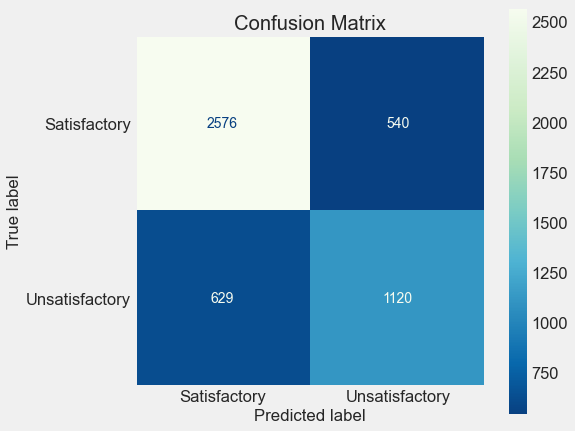

,Accuracy,F1,Recall,Precision
0,0.759712,0.657084,0.640366,0.674699


time: 707 ms


In [51]:
f.confusion_report(best_model, X_holdout, y_holdout)

## Score Interpretation:

Upon validation with the holdout data we see that the model is still having some trouble the minority class, but performance is at a level that is acceptable for our purposes.

- The recall score of .64 indicates that about 64% outcomes were correctly classified as Unsatisfactory.
- The precision score .67 indicates that about 67% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

## Sources

1. "The Evolution of Distance Education in 2020." *KU Online Degrees Blog*, 17 September 2020, https://educationonline.ku.edu/community/distance-education-evolution-in-2020.

2. Koksal, Ilker. "The Rise Of Online Learning."  *Forbes.com*, 2 May 2020, www.forbes.com/sites/ilkerkoksal/2020/05/02/the-rise-of-online-learning/.

3. Johnson Hess, Abigail."Online learning boomed during the pandemic—but what happens when students return to classrooms?." *www.cnbc.com*, 26 March 2021, www.cnbc.com/2021/03/26/online-learning-boomed-during-the-pandemic-but-soon-students-return-to-school.html.

4. McElrath, Kevin. "Nearly 93% of Households With School-Age Children Report Some Form of Distance Learning During COVID-19." *census.gov*, 26 August 2020, www.census.gov/library/stories/2020/08/schooling-during-the-covid-19-pandemic.html.

5. NASPA Foundation & Course Hero. "Student Wellness During Covid-19." October 2020, https://marketplace.collegepulse.com/img/student_wellness_collegepulse_final.pdf.

6. 
Donnelly, Robin &  Patrinos, Harry A. "Is the COVID-19 slide in education real?." *blogs.worldbank.org*, 8 December 2020, https://blogs.worldbank.org/education/covid-19-slide-education-real

7. Johnson Hess, Abigail. "7 ways the coronavirus pandemic could change college this fall and forever." *www.cnbc.com* June 19 2020,
www.cnbc.com/2020/06/19/7-ways-coronavirus-pandemic-may-change-college-this-fall-and-forever.html